In [8]:
import numpy as np
import pandas as pd
import sklearn.metrics as metrics
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
import keras
from tensorflow.keras.utils import to_categorical

%matplotlib inline
from matplotlib.colors import ListedColormap
import warnings
warnings.filterwarnings("ignore")

plt.close()


In [20]:
dir_train_images  = './training/'
dir_test_images   = './testing/'
dir_train_labels  = 'labels_training.csv'
dir_test_ids      = 'sample_submission.csv'

In [15]:
# from kyle's code load data
def load_data(dir_data, dir_labels, training=True):
    ''' Load each of the image files into memory 

    While this is feasible with a smaller dataset, for larger datasets,
    not all the images would be able to be loaded into memory

    When training=True, the labels are also loaded
    '''
    labels_pd = pd.read_csv(dir_labels)
    ids       = labels_pd.id.values
    data      = []
    for identifier in ids:
        fname     = dir_data + identifier.astype(str) + '.tif'
        image     = mpl.image.imread(fname)
        data.append(image)
    data = np.array(data) # Convert to Numpy array
    if training:
        labels = labels_pd.label.values
        return data, labels
    else:
        return data, ids

In [16]:
# from kyle's code draw roc
def plot_roc(labels, prediction_scores, title='ROC'):
    fpr, tpr, _ = metrics.roc_curve(labels, prediction_scores, pos_label=1)
    auc = metrics.roc_auc_score(labels, prediction_scores)
    legend_string = 'AUC = {:0.3f}'.format(auc)
       
    plt.figure(figsize=(10,8))
    plt.plot([0,1],[0,1],'--', color='gray', label='Chance')
    plt.plot(fpr, tpr, label=legend_string, color = 'red')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.grid()
    plt.axis('square')
    plt.title(title)
    plt.legend()
    plt.tight_layout()

In [21]:
# trainning with y labels
data, ylabel = load_data(dir_train_images, dir_train_labels, training=True)
# test dataset for kaggle
testd, ids = load_data(dir_test_images, dir_test_ids, training=False) 

data = data.astype('float32')
data /= 255
testd = testd.astype('float32')
testd /= 255

input_shape = 101, 101, 3

In [22]:
# split the trainning data into 8-2 ratio of trainning and validation
xtr, xva, ytr, yva = train_test_split(data, ylabel, test_size=0.2, random_state=423)

In [23]:
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout

# build the CNN model
cnn_model = Sequential()

# 1st layer
cnn_model.add(Conv2D(32, (3, 3), input_shape = input_shape, activation = 'relu', padding = 'same'))
cnn_model.add(MaxPooling2D(pool_size = (2, 2)))

# 2nd layer
cnn_model.add(Conv2D(64, (3, 3), activation = 'relu', padding = 'same'))
cnn_model.add(MaxPooling2D(pool_size = (2, 2)))

# 3rd layer
# start throw away half of the data out
cnn_model.add(Conv2D(128, (3, 3), activation = 'relu', padding = 'same'))
cnn_model.add(MaxPooling2D(pool_size = (2, 2)))
cnn_model.add(Dropout(0.5))

# 4th layer
cnn_model.add(Conv2D(256, (3, 3), activation = 'relu', padding = 'same'))
cnn_model.add(MaxPooling2D(pool_size = (2, 2)))
cnn_model.add(Dropout(0.5))

# 5th layer
cnn_model.add(Conv2D(128, (3, 3), activation = 'relu', padding = 'same'))
cnn_model.add(MaxPooling2D(pool_size = (2, 2)))
cnn_model.add(Dropout(0.5))

# transform
cnn_model.add(Flatten())
cnn_model.add(Dense(units = 64, activation = 'relu'))
cnn_model.add(Dense(units = 1, activation = 'sigmoid'))

cnn_model.compile(loss=keras.losses.binary_crossentropy,
          optimizer=keras.optimizers.Adam(),
          metrics=['accuracy'])

In [24]:
cnn_fit = cnn_model.fit(data, ylabel, batch_size=100,epochs=50, verbose=1,validation_data=(xva, yva))

Epoch 1/50
15/15 [==============================] - 28s 993ms/step - loss: 0.6651 - accuracy: 0.6596 - val_loss: 0.6364 - val_accuracy: 0.7100
Epoch 2/50
15/15 [==============================] - 14s 946ms/step - loss: 0.6413 - accuracy: 0.6716 - val_loss: 0.6383 - val_accuracy: 0.7100
Epoch 3/50
15/15 [==============================] - 15s 981ms/step - loss: 0.6451 - accuracy: 0.6736 - val_loss: 0.6436 - val_accuracy: 0.7100
Epoch 4/50
15/15 [==============================] - 15s 974ms/step - loss: 0.6416 - accuracy: 0.6736 - val_loss: 0.6504 - val_accuracy: 0.7100
Epoch 5/50
15/15 [==============================] - 14s 959ms/step - loss: 0.6516 - accuracy: 0.6526 - val_loss: 0.6291 - val_accuracy: 0.7100
Epoch 6/50
15/15 [==============================] - 14s 959ms/step - loss: 0.6468 - accuracy: 0.6490 - val_loss: 0.6122 - val_accuracy: 0.7100
Epoch 7/50
15/15 [==============================] - 14s 956ms/step - loss: 0.6313 - accuracy: 0.6703 - val_loss: 0.6296 - val_accuracy: 0.7100

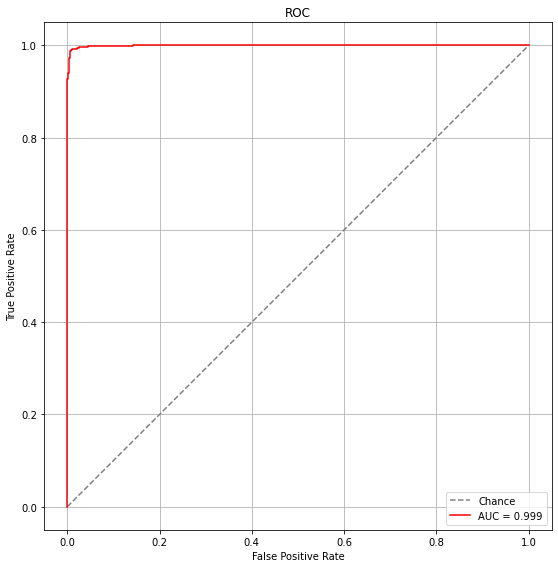

In [25]:
# plot ROC
pred = cnn_model.predict(data) 
plot_roc(ylabel, pred)

In [26]:
pred1  = pred.reshape((pred.shape[0],))
roc_file = pd.DataFrame({'y':    ylabel,'pred':  pred1})
roc_file.to_csv('finalresultsubmission.csv',
                           columns=['y','pred'],
                           index=False)